In [83]:
import numpy as np
import matplotlib.pyplot as plt
from HandyFunctions import calc_scale_height, convert_rprs_to_rpJ, calc_scale_height_error, convert_km_to_rpJ, convert_rpJ_to_rprs
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [84]:
def T14_analytic(P, aRs, RpRs, b, i):
    # P in [arbitrary], a/Rs, Rp/Rs, b, i in [deg]
    pref = P / np.pi # in [P]
    num = np.sqrt((1. + RpRs)**2 - b**2) # unitless
    den = (aRs * np.sin(i*(np.pi/180.))) # unitless
    term = num/den # unitless
    tdur = pref*np.arcsin(term) # in [P]
    return tdur

In [95]:
## mock planet properties
aRs = 2.0
P = 0.3 # [day]
r = 0.5 # RpRs
b = 0.5
i = 90.0 # [deg]

In [96]:
## -- velocity profile throughout orbit
t = np.linspace(-1.*P/5., 1.*P/5., 50) # times thru orbit
w = 2.*np.pi/P # angular frequency [radians/day]
theta = w*t # angular phase as func. of time
vorb = w*aRs # tangential velocity [Rstar / day]

x = aRs*np.cos(w*t) # coords as function of time, units of [Rs]
y = aRs*np.sin(w*t)

vx = vorb*abs(np.sin(w*t)) # speed as function of time,
vy = vorb*abs(np.cos(w*t))

## -- estimate when transit is happening
duration = T14_analytic(P, aRs, r, b, i) # transit duration in [day]
t1 = -0.5*duration # time of first contact in [day]
theta1 = w*t1 # angular phase at first contact
y1 = aRs*np.sin(theta1) # coord. at first contact
vy1 = vorb*abs(np.cos(theta1)) # speed at first contact

print('First contact')
print('Relative Projected Speed = ', (vy1/vorb))

First contact
Relative Projected Speed =  0.7071067811865476


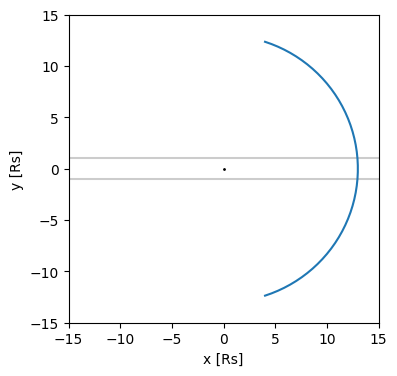

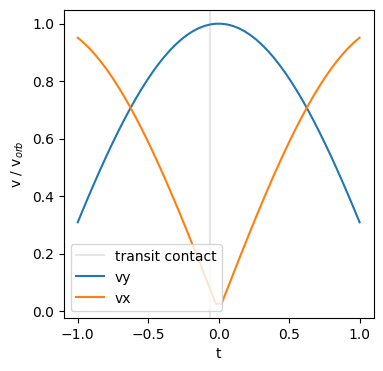

In [32]:
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter([0],[0], c='black', s=1)
ax.axhline(y1, c='black', alpha=0.2)
ax.axhline(-y1, c='black', alpha=0.2) # assume T1 and T4 symmetric about Tmid
ax.plot(x,y)
ax.set(xlim=(-15,15), ylim=(-15,15))
ax.set(xlabel='x [Rs]', ylabel='y [Rs]')
plt.show()



fig, ax = plt.subplots(figsize=(4,4))
ax.axvline(t1, c='black', alpha=0.1, label='transit contact')
ax.plot(t,vy/vorb, label='vy')
ax.plot(t, vx/vorb, label='vx')
#ax.set(xlim=(-2,2), ylim=(-2,2))
ax.set(xlabel='t', ylabel='v / v$_{orb}$')
ax.legend(loc='lower left')
plt.show()

In [33]:
AU_to_meter = 1.496e11
day_to_second = 24.*60.*60.
Rsun_to_meter = 6.957e8
Rjup_to_meter = 7.149e7

In [76]:
def compute_vx(P, aRs, Rs, RpRs, b, i):
    #   a given as a/Rs,
    a_meter = aRs*Rsun_to_meter
    #   P given in days
    P_sec = P*day_to_second
    w = 2.*np.pi/(P_sec) # angular freq. in [radians/s]
    vorb = w*a_meter # [m/s]
    # compute correction for velocity at ingress
    tdur = T14_analytic(P_sec, aRs, RpRs, b, i) # [sec]
    t1 = -0.5*tdur # [sec], relative to time of midpoint
    theta1 = w*t1 # angular phase at first contact, relative to 0 = transit mid
    v1 = vorb*abs(np.cos(theta1)) # speed at first contact
    return v1

def predict_dT1(rm, ru, vx, Rs):
    # dT1 = d rm / v
    # compute change in Rp/Rs
    drm = rm - ru
    # compute corresponding change in Rp (in meters)
    drm_meter = drm*Rs*Rsun_to_meter
    # compute change in time [s]
    dT1 = drm_meter / vx
    return dT1/day_to_second

def predict_dT4(re, ru, vx, Rs):
    # dT1 = d rm / v
    dre = re - ru
    dre_meter = dre*Rs*Rsun_to_meter
    dT4 = dre_meter / vx
    return dT4/day_to_second
   
def predict_dT14(dT1, dT4):
    dT14 = dT4 + dT1
    return dT14

def predict_dtmid(dT1, dT4):
    dtmid = 0.5*(abs(dT1) + abs(dT4))
    return dtmid

In [80]:
## -- calculating an example for wasp-39 b
# load in fAsyms used
resAw39= np.load('output_arrays/wasp39b_synth_scatter100_ahead1000LDscenA_nircCadencekeyoutputs.npz')
fAw39, tAw39, terrAw39 = resAw39['fasyms'], resAw39['tdiff_seconds'], resAw39['tdiff_err_seconds']
# define properties
M_w39, T_w39, RpRs_w39, Rs_w39, mu_w39 = 0.281, 1166., 0.1457, 0.928, 2.3 # [Mj], [K],[], [Rsol]
Merr_w39, Terr_w39, RpRserr_w39, Rserr_w39, muerr_w39 = 0.032, 14., 0.0015, 0.03, 0.25
a_w39, P_w39 = 11.55, 4.055259 # [Rs], [day]
b_w39 = 0.447
inc_w39 = 87.83 # [deg]

# calculate physical radius
Rp1_w39 = convert_rprs_to_rpJ(RpRs_w39, Rs_w39) # in [Rjupiter]
Rp1_m_w39 = Rp1_w39*Rjup_to_meter #[m]

# compute scale height
H_w39 = calc_scale_height(T_w39, M_w39, Rp1_w39, mu_w39) * 1000. # [m]
# convert scale height to rp


# compute starting limb radius (i.e. evening)
Rp1_w39 = convert_rprs_to_rpJ(RpRs_w39, Rs_w39) # in [Rjupiter]
# compute scale height
H_w39 = calc_scale_height(T_w39, M_w39, Rp1_w39, mu_w39) # [km]
H_Rj_w39 = convert_km_to_rpJ(H_w39)
# compute morning limb radii
Rp2vals_w39 = Rp1_w39 + (fAw39*H_Rj_w39) # in [Rjupiter]
# compute corresponding RpRs values
r1_w39 = convert_rpJ_to_rprs(Rp1_w39, Rs_w39)
r2vals_w39 = convert_rpJ_to_rprs(Rp2vals_w39, Rs_w39)
# compute equivalent depth uniform Rp/Rs values
rpuvals_w39 = np.sqrt(0.5*(r1_w39**2 + r2vals_w39**2))

# compute velocity at ingress
v1_w39 = compute_vx(P_w39, a_w39, Rs_w39, RpRs_w39, b_w39, inc_w39) # in m/s
R0 = Rp1_w39*Rjup_to_meter # in [m]
dRvals = (fAw39 * H_Rj_w39 * Rjup_to_meter) # in [m]

dt_preds = np.zeros(len(dRvals))
for i, dR in enumerate(dRvals):
    num = dR #(2.*R0 + dR) - (2.*np.sqrt((R0**2) + (R0*dR) + (dR**2)))
    #$print(num/dR)
    dt_preds[i] = num / (2.*v1_w39) # in [s]




# # compute predicted change in T1 in [day]
# dT1vals_w39 = predict_dT1(r2vals_w39, rpuvals_w39, v1_w39, Rs_w39)
# # compute predicted change in T4 in [day]
# dT4vals_w39 = predict_dT4(r1_w39, rpuvals_w39, v1_w39, Rs_w39)
# # compute predicted change in midtime in [day]
# dTmedvals_w39 = predict_dtmid(dT1vals_w39, dT4vals_w39)

In [81]:
dt_preds

array([  3.46617495,  10.39852484,  17.33087473,  25.99631209,
        34.66174946,  51.99262419,  69.32349892,  86.65437365,
       103.98524838, 121.31612311, 138.64699784, 155.97787256,
       173.30874729])

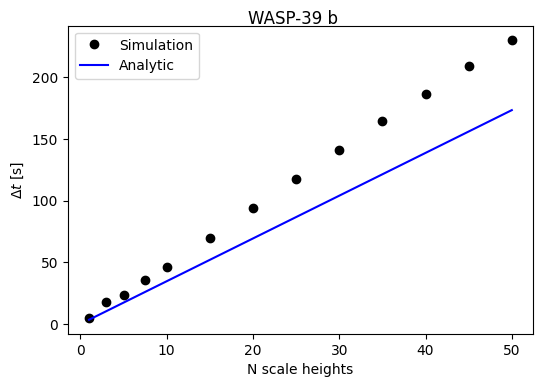

In [82]:
## plot
fig, ax = plt.subplots(figsize=(6,4))
fig.suptitle('WASP-39 b', y=0.92)
ax.plot(fAw39, abs(tAw39), marker='o', ls='None', c='black', label='Simulation')
ax.plot(fAw39, abs(dt_preds), c='blue', label='Analytic')
# ax.plot(fAw39, abs(dTmedvals_w39)*day_to_second, c='blue', label='Analytic')
# ax.plot(fAw39, 1.22*abs(dTmedvals_w39)*day_to_second, c='green', label='1.22 * Analytic')
ax.set(xlabel='N scale heights', ylabel='$\Delta t$ [s]')
ax.legend(loc='upper left')
#ax.set(xlim=(0,20))
plt.show()

In [ ]:
dTmedvals_w39

In [ ]:
## WASP-39 b numerical results
# with PandExo cadence, 100 ppm scatter, ahead 1k
resAw39= np.load('output_arrays/wasp39b_synth_scatter100_ahead1000LDscenA_nircCadencekeyoutputs.npz')
fAw39, tAw39, terrAw39 = resAw39['fasyms'], resAw39['tdiff_seconds'], resAw39['tdiff_err_seconds']
resBw39 = np.load('output_arrays/wasp39b_synth_scatter100_ahead1000LDscenB_nircCadencekeyoutputs.npz')
fBw39, tBw39, terrBw39 = resBw39['fasyms'], resBw39['tdiff_seconds'], resBw39['tdiff_err_seconds']
resCw39 = np.load('output_arrays/wasp39b_synth_scatter100_ahead1000LDscenC_nircCadencekeyoutputs.npz')
fCw39, tCw39, terrCw39 = resCw39['fasyms'], resCw39['tdiff_seconds'], resCw39['tdiff_err_seconds']
fw39, tw39, terrw39 = np.concatenate((fAw39, fBw39, fCw39)), np.concatenate((tAw39, tBw39, tCw39)),np.concatenate((terrAw39, terrBw39, terrCw39))

# with PandExo cadence, 100 ppm scatter, ahead 1k, test of uniform Rp/Rs
# resAw39ut= np.load('output_arrays/wasp39b_utest_synth_scatter100_ahead1000LDscenA_nircCadencekeyoutputs.npz')
# fAw39ut, tAw39ut, terrAw39ut = resAw39ut['fasyms'], resAw39ut['tdiff_seconds'], resAw39ut['tdiff_err_seconds']
# resBw39ut = np.load('output_arrays/wasp39b_utest_synth_scatter100_ahead1000LDscenB_nircCadencekeyoutputs.npz')
# fBw39ut, tBw39ut, terrBw39ut = resBw39ut['fasyms'], resBw39ut['tdiff_seconds'], resBw39ut['tdiff_err_seconds']
resCw39ut = np.load('output_arrays/wasp39b_utest3_synth_scatter750_ahead1000LDscenC_nircCadencekeyoutputs.npz')
fCw39ut, tCw39ut, terrCw39ut = resCw39ut['fasyms'], resCw39ut['tdiff_seconds'], resCw39ut['tdiff_err_seconds']
#fw39ut, tw39ut, terrw39ut = np.concatenate((fAw39ut, fBw39ut, fCw39ut)), np.concatenate((tAw39ut, tBw39ut, tCw39ut)),np.concatenate((terrAw39ut, terrBw39ut, terrCw39ut))
    
    
## analytic calc
dRp = fAw39*H_w39*1000. # [m]
dt_analytic = calc_dt(dRp, (a_w39*AU_to_meter), (P_w39*day_to_second))

## plot
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(fAw39, abs(tAw39), marker='o', ls='None', c='black', label='Simulation')
ax.plot(fCw39ut, abs(tCw39ut), marker='s', ls='None', c='black', label='Simulation, Utest')
ax.plot(fAw39, dt_analytic, c='black', label='Analytical Prediction')
ax.plot(fAw39, 1.22*dt_analytic, c='black', ls='--', label='1.22 * Analytical Prediction')
ax.set(xlabel='N scale heights', ylabel='$\Delta t$ [s]')
ax.legend(loc='upper left')
#ax.set(xlim=(0,20))
plt.show()

In [ ]:
## WASP-96 b results
# with PandExo cadence, 100 ppm scatter, ahead 1k
resAw96= np.load('output_arrays/synth_scatter100_ahead1000LDscenA_nircCadencekeyoutputs.npz')
fAw96, tAw96, terrAw96 = resAw96['fasyms'], resAw96['tdiff_seconds'], resAw96['tdiff_err_seconds']
resBw96 = np.load('output_arrays/synth_scatter100_ahead1000LDscenB_nircCadencekeyoutputs.npz')
fBw96, tBw96, terrBw96 = resBw96['fasyms'], resBw96['tdiff_seconds'], resBw96['tdiff_err_seconds']
resCw96 = np.load('output_arrays/synth_scatter100_ahead1000LDscenC_nircCadencekeyoutputs.npz')
fCw96, tCw96, terrCw96 = resCw96['fasyms'], resCw96['tdiff_seconds'], resCw96['tdiff_err_seconds']
fw96, tw96, terrw96 = np.concatenate((fAw96, fBw96, fCw96)), np.concatenate((tAw96, tBw96, tCw96)), np.concatenate((terrAw96, terrBw96, terrCw96))

## WASP-107 b results
# with PandExo cadence, 100 ppm scatter, ahead 1k
resAw107= np.load('output_arrays/wasp107b_synth_scatter100_ahead1000LDscenA_nircCadencekeyoutputs.npz')
fAw107, tAw107, terrAw107 = resAw107['fasyms'], resAw107['tdiff_seconds'], resAw107['tdiff_err_seconds']
resBw107 = np.load('output_arrays/wasp107b_synth_scatter100_ahead1000LDscenB_nircCadencekeyoutputs.npz')
fBw107, tBw107, terrBw107 = resBw107['fasyms'], resBw107['tdiff_seconds'], resBw107['tdiff_err_seconds']
resCw107 = np.load('output_arrays/wasp107b_synth_scatter100_ahead1000LDscenC_nircCadencekeyoutputs.npz')
fCw107, tCw107, terrCw107 = resCw107['fasyms'], resCw107['tdiff_seconds'], resCw107['tdiff_err_seconds']
fw107, tw107, terrw107 = np.concatenate((fAw107, fBw107, fCw107)), np.concatenate((tAw107, tBw107, tCw107)),np.concatenate((terrAw107, terrBw107, terrCw107))

## GJ-1214 b results
# with PandExo cadence, 100 ppm scatter, ahead 1k
resAgj1214= np.load('output_arrays/gj1214b_synth_scatter100_ahead1000LDscenA_nircCadencekeyoutputs.npz')
fAgj1214, tAgj1214, terrAgj1214 = resAgj1214['fasyms'], resAgj1214['tdiff_seconds'], resAgj1214['tdiff_err_seconds']
resBgj1214 = np.load('output_arrays/gj1214b_synth_scatter100_ahead1000LDscenB_nircCadencekeyoutputs.npz')
fBgj1214, tBgj1214, terrBgj1214 = resBgj1214['fasyms'], resBgj1214['tdiff_seconds'], resBgj1214['tdiff_err_seconds']
resCgj1214 = np.load('output_arrays/gj1214b_synth_scatter100_ahead1000LDscenC_nircCadencekeyoutputs.npz')
fCgj1214, tCgj1214, terrCgj1214 = resCgj1214['fasyms'], resCgj1214['tdiff_seconds'], resCgj1214['tdiff_err_seconds']
fgj1214, tgj1214, terrgj1214 = np.concatenate((fAgj1214, fBgj1214, fCgj1214)), np.concatenate((tAgj1214, tBgj1214, tCgj1214)), np.concatenate((terrAgj1214, terrBgj1214, terrCgj1214))
 
## WASP-39 b results
# with PandExo cadence, 100 ppm scatter, ahead 1k
resAw39= np.load('output_arrays/wasp39b_synth_scatter100_ahead1000LDscenA_nircCadencekeyoutputs.npz')
fAw39, tAw39, terrAw39 = resAw39['fasyms'], resAw39['tdiff_seconds'], resAw39['tdiff_err_seconds']
resBw39 = np.load('output_arrays/wasp39b_synth_scatter100_ahead1000LDscenB_nircCadencekeyoutputs.npz')
fBw39, tBw39, terrBw39 = resBw39['fasyms'], resBw39['tdiff_seconds'], resBw39['tdiff_err_seconds']
resCw39 = np.load('output_arrays/wasp39b_synth_scatter100_ahead1000LDscenC_nircCadencekeyoutputs.npz')
fCw39, tCw39, terrCw39 = resCw39['fasyms'], resCw39['tdiff_seconds'], resCw39['tdiff_err_seconds']
fw39, tw39, terrw39 = np.concatenate((fAw39, fBw39, fCw39)), np.concatenate((tAw39, tBw39, tCw39)),np.concatenate((terrAw39, terrBw39, terrCw39))
    
## WASP-80 b results
# with PandExo cadence, 100 ppm scatter, ahead 1k
resAw80= np.load('output_arrays/wasp80b_synth_scatter100_ahead1000LDscenA_nircCadencekeyoutputs.npz')
fAw80, tAw80, terrAw80 = resAw80['fasyms'], resAw80['tdiff_seconds'], resAw80['tdiff_err_seconds']
resBw80 = np.load('output_arrays/wasp80b_synth_scatter100_ahead1000LDscenB_nircCadencekeyoutputs.npz')
fBw80, tBw80, terrBw80 = resBw80['fasyms'], resBw80['tdiff_seconds'], resBw80['tdiff_err_seconds']
resCw80 = np.load('output_arrays/wasp80b_synth_scatter100_ahead1000LDscenC_nircCadencekeyoutputs.npz')
fCw80, tCw80, terrCw80 = resCw80['fasyms'], resCw80['tdiff_seconds'], resCw80['tdiff_err_seconds']
fw80, tw80, terrw80 = np.concatenate((fAw80, fBw80, fCw80)), np.concatenate((tAw80, tBw80, tCw80)),np.concatenate((terrAw80, terrBw80, terrCw80))    
    
## Limb darkening coefficient cases
u1A, u2A= 0.1777 , 0.2952
u1B, u2B = 0.25, 0.45
u1C, u2C = 0.6, 0.2952

# Prop t0 uncertainties after 1,000 transits
propw96 = 1.235466*60. #[s]
propw107 = 4.341546*60.
propgj1214 = 0.209944*60.
propw39 = 4.979340*60.
propw80 = 0.279597*60.

## computing the scale heights as done in the simulations
M_w96, T_w96, RpRs_w96, Rs_w96, mu_w96 = 0.49, 1285., 0.1186, 1.15, 2.3
Merr_w96, Terr_w96, RpRserr_w96, Rserr_w96, muerr_w96 = 0.04, 40., 0.0017, 0.03, 0.25
a_w96, P_w96 = 0.0453, 3.4252602 # [au], [day]
b_w96 = 0.710
Rp1_w96 = convert_rprs_to_rpJ(RpRs_w96, Rs_w96)
Rp1err_w96 = 9.73116*np.sqrt((Rs_w96**2 * RpRserr_w96**2) + (RpRs_w96**2 * Rserr_w96**2)) # 9.7... = Rsun -> Rjup conversion
H_w96 = calc_scale_height(T_w96, M_w96, Rp1_w96, mu_w96)
Herr_w96 = calc_scale_height_error(T_w96, M_w96, Rp1_w96, mu_w96, Terr_w96, Merr_w96, Rp1err_w96, muerr_w96)

M_w107, T_w107, RpRs_w107, Rs_w107, mu_w107 = 0.096, 770., 0.14434, 0.73, 2.3
Merr_w107, Terr_w107, RpRserr_w107, Rserr_w107, muerr_w107 = 0.005, 60., 0.00018, 0.15, 0.25
a_w107, P_w107 = 0.055, 5.721488 # [au], [day]
b_w107 = 0.090
Rp1_w107 = convert_rprs_to_rpJ(RpRs_w107, Rs_w107)
Rp1err_w107 = 0.02 # using this one is inflated by Rs err -> 9.73116*np.sqrt((Rs_w107**2 * RpRserr_w107**2) + (RpRs_w107**2 * Rserr_w107**2))
H_w107 = calc_scale_height(T_w107, M_w107, Rp1_w107, mu_w107)
Herr_w107 = calc_scale_height_error(T_w107, M_w107, Rp1_w107, mu_w107, Terr_w107, Merr_w107, Rp1err_w107, muerr_w107)

M_gj1214, T_gj1214, RpRs_gj1214, Rs_gj1214, mu_gj1214 = 0.0257, 596., 0.1160, 0.215, 5.0
Merr_gj1214, Terr_gj1214, RpRserr_gj1214, Rserr_gj1214, muerr_gj1214 = 0.0014, 19., 0.0005, 0.008, 0.25
a_gj1214, P_gj1214 = 0.01490, 1.5804043 # [au], [day]
b_gj1214 = 0.325
Rp1_gj1214 = convert_rprs_to_rpJ(RpRs_gj1214, Rs_gj1214)
Rp1err_gj1214 = 9.73116*np.sqrt((Rs_gj1214**2 * RpRserr_gj1214**2) + (RpRs_gj1214**2 * Rserr_gj1214**2))
H_gj1214 = calc_scale_height(T_gj1214, M_gj1214, Rp1_gj1214, mu_gj1214)
Herr_gj1214 = calc_scale_height_error(T_gj1214, M_gj1214, Rp1_gj1214, mu_gj1214, Terr_gj1214, Merr_gj1214, Rp1err_gj1214, muerr_gj1214)

M_w39, T_w39, RpRs_w39, Rs_w39, mu_w39 = 0.281, 1166., 0.1457, 0.928, 2.3
Merr_w39, Terr_w39, RpRserr_w39, Rserr_w39, muerr_w39 = 0.032, 14., 0.0015, 0.03, 0.25
a_w39, P_w39 = 0.0486, 4.055259 # [AU], [day]
b_w39 = 0.447
Rp1_w39 = convert_rprs_to_rpJ(RpRs_w39, Rs_w39)
Rp1err_w39 = 9.73116*np.sqrt((Rs_w39**2 * RpRserr_w39**2) + (RpRs_w39**2 * Rserr_w39**2))
H_w39 = calc_scale_height(T_w39, M_w39, Rp1_w39, mu_w39)
Herr_w39 = calc_scale_height_error(T_w39, M_w39, Rp1_w39, mu_w39, Terr_w39, Merr_w39, Rp1err_w39, muerr_w39)

M_w80, T_w80, RpRs_w80, Rs_w80, mu_w80 = 0.538, 825., 0.17137, 0.605, 2.3
Merr_w80, Terr_w80, RpRserr_w80, Rserr_w80, muerr_w80 = 0.035, 19., 0.00039, 0.048, 0.25
a_w80, P_w80 = 0.0344, 3.0678523 # [au], [day]
b_w80 = 0.215
Rp1_w80 = convert_rprs_to_rpJ(RpRs_w80, Rs_w80)
Rp1err_w80 = 9.73116*np.sqrt((Rs_w80**2 * RpRserr_w80**2) + (RpRs_w80**2 * Rserr_w80**2))
H_w80 = calc_scale_height(T_w80, M_w80, Rp1_w80, mm=mu_w80)
Herr_w80 = calc_scale_height_error(T_w80, M_w80, Rp1_w80, mu_w80, Terr_w80, Merr_w80, Rp1err_w80, muerr_w80)

Teqs = np.array([T_gj1214, T_w80, T_w96, T_w39, T_w107])
radii1 = np.array([Rp1_gj1214, Rp1_w80, Rp1_w96, Rp1_w39, Rp1_w107])
masses = np.array([M_gj1214, M_w80, M_w96, M_w39, M_w107])
scaleheights = np.array([H_gj1214, H_w80, H_w96, H_w39, H_w107])
scaleheight_errs = np.array([Herr_gj1214, Herr_w80, Herr_w96, Herr_w39, Herr_w107])

labels = np.array(['GJ-1214 b', 'WASP-80 b', 'WASP-96 b', 'WASP-39 b', 'WASP-107 b'])

In [ ]:
## analytic calc
dt_gj1214 = calc_dt_nofac((fAgj1214*H_gj1214*1000.), (a_gj1214*AU_to_meter), (P_gj1214*day_to_second))
dt_w80 = calc_dt_nofac((fAw80*H_w80*1000.), (a_w80*AU_to_meter), (P_w80*day_to_second))
dt_w96 = calc_dt_nofac((fAw96*H_w96*1000.), (a_w96*AU_to_meter), (P_w96*day_to_second))
dt_w39 = calc_dt_nofac((fAw39*H_w39*1000.), (a_w39*AU_to_meter), (P_w39*day_to_second))
dt_w107 = calc_dt_nofac((fAw107*H_w107*1000.), (a_w107*AU_to_meter), (P_w107*day_to_second))

In [ ]:
## plot
fig, ax = plt.subplots(figsize=(8,5))
#ax.plot(fAgj1214, abs(tAgj1214), marker='s', ls='None', c='black', label='GJ-1214 b')
#ax.plot(fAw80, abs(tAw80), marker='o', ls='None', c='blue', label='WASP-80 b')
#ax.plot(fAw96, abs(tAw96), marker='*', ls='None', c='green', label='WASP-96 b')
ax.plot(fAw39, abs(tAw39), marker='^', ls='None', c='purple', label='WASP-39 b')
#ax.plot(fAw107, abs(tCw107), marker='d', ls='None', c='red', label='WASP-107 b')

#ax.plot(fAgj1214, 1.22*dt_gj1214, c='black')
#ax.plot(fAw80, 1.22*dt_w80, c='blue')
#ax.plot(fAw96, 1.22*dt_w96, c='green')
ax.plot(fAw39, 0.6*dt_w39, c='purple')
#ax.plot(fAw107, 1.22*dt_w107, c='red')
ax.legend(loc='best')
plt.show()

In [ ]:
## Plotting the full f_asym vs. t diff data
fig, ax = plt.subplots(figsize=(10,5))

cutoff = 8

## W-107 b
#ax.axhline(propw107, ls='None', c='black', lw=2, alpha=0.5)
ax.text(0.7, 0.92, 'WASP-107 b', c='black', fontsize=12, transform=ax.transAxes)
ax.errorbar(fAw107[:cutoff], abs(tAw107)[:cutoff], terrAw107[:cutoff], ls='None', marker='o', ms=7, c='black')
ax.errorbar(fBw107[:cutoff], abs(tBw107)[:cutoff], terrBw107[:cutoff], ls='None', marker='o', ms=7, c='black')
ax.errorbar(fCw107[:cutoff], abs(tCw107)[:cutoff], terrCw107[:cutoff], ls='None', marker='o', ms=7, c='black')
## W-39 b
#ax.axhline(propw39, ls='--', c='black', lw=2, alpha=0.5)
ax.text(0.85, 0.82, 'WASP-39 b', c='black', fontsize=12, transform=ax.transAxes)
ax.errorbar(fAw39[:cutoff], abs(tAw39)[:cutoff], terrAw39[:cutoff], ls='None', marker='s', ms=7, c='black')
ax.errorbar(fBw39[:cutoff], abs(tBw39)[:cutoff], terrBw39[:cutoff], ls='None', marker='s', ms=7, c='black')
ax.errorbar(fCw39[:cutoff], abs(tCw39)[:cutoff], terrCw39[:cutoff], ls='None', marker='s', ms=7, c='black')
## W-96 b
#ax.axhline(propw96, ls='dotted', c='black', lw=2, alpha=0.5)
ax.text(0.85, 0.47, 'WASP-96 b', c='black', fontsize=12, transform=ax.transAxes)
ax.errorbar(fAw96[:cutoff], abs(tAw96)[:cutoff], terrAw96[:cutoff], ls='None', marker='d', ms=7, c='black')
ax.errorbar(fBw96[:cutoff], abs(tBw96)[:cutoff], terrBw96[:cutoff], ls='None', marker='d', ms=7, c='black')
ax.errorbar(fCw96[:cutoff], abs(tCw96)[:cutoff], terrCw96[:cutoff], ls='None', marker='d', ms=7, c='black')
## W-80 b
#ax.axhline(propw80, ls='dashdot', c='black', lw=2, alpha=0.5)
ax.text(0.85, 0.20, 'WASP-80 b', c='black', fontsize=12, transform=ax.transAxes)
ax.errorbar(fAw80[:cutoff], abs(tAw80)[:cutoff], terrAw80[:cutoff], ls='None', marker='^', ms=7, c='black')
ax.errorbar(fBw80[:cutoff], abs(tBw80)[:cutoff], terrBw80[:cutoff], ls='None', marker='^', ms=7, c='black')
ax.errorbar(fCw80[:cutoff], abs(tCw80)[:cutoff], terrCw80[:cutoff], ls='None', marker='^', ms=7, c='black')
## gj-1214 b
#ax.axhline(propgj1214, ls=(5,(6,6)), c='black', lw=2, alpha=0.5)
ax.text(0.85, 0.03, 'GJ-1214 b', c='black', fontsize=12, transform=ax.transAxes)
ax.errorbar(fAgj1214[:cutoff], abs(tAgj1214)[:cutoff], terrAgj1214[:cutoff], ls='None', marker='x', ms=7, c='black')
ax.errorbar(fBgj1214[:cutoff], abs(tBgj1214)[:cutoff], terrBgj1214[:cutoff], ls='None', marker='x', ms=7, c='black')
ax.errorbar(fCgj1214[:cutoff], abs(tCgj1214)[:cutoff], terrCgj1214[:cutoff], ls='None', marker='x', ms=7, c='black')

ax.plot(fAgj1214, 1.22*dt_gj1214, c='black')
ax.plot(fAw80, 1.22*dt_w80, c='blue')
ax.plot(fAw96, 1.22*dt_w96, c='green')
ax.plot(fAw39, 1.22*dt_w39, c='purple')
ax.plot(fAw107, 1.12*dt_w107, c='red')

# custom_legend_lines = [
#                        Line2D([0],[0], color='blue', lw=3, ls='None'), Line2D([0],[0], color='black', lw=3, ls='None'),
#                        Line2D([0],[0], color='teal', lw=3, ls='None')#, Line2D([0],[0], c='black', lw=2, ls='None', alpha=0.5)
#                       ]
# custom_legend_labels = ['$u_1$ = %.2f, $u_2$ = %.2f'%(u1A, u2A), 
#                        '$u_1$ = %.2f, $u_2$ = %.2f'%(u1B, u2B), '$u_1$ = %.2f, $u_2$ = %.2f'%(u1C, u2C), 'Propagated $\sigma_{t_0}$']
#ax.text(0.01, 0.51, 'Scatter = 100 ppm', fontsize=9, transform=ax.transAxes)
ax.set(ylim=(0, 150))
ax.set(xlim=(0, 26))
# ax.set_xlabel('Mimicked Limb Asymmetry [$\Delta R_p$ in units scale heights]', fontsize=12)
# ax.set_ylabel('|Transit midpoint time variation [s]|', fontsize=12)
ax.set_xlabel('(Intrinsic limb radii difference [scale heights])\n'+r'$\bf{Smallest \ resolvable \ limb \ asymmetry \  [\Delta R_p \ in \ scale \ heights]}$', fontsize=11)
ax.set_ylabel(r'$\bf{Transit \ time \ uncertainty \ \sigma_{t_0} \ [s]}$'+'\n (|t$_{best~fit}$ - t$_{true}$| [s])', fontsize=11)
#ax.legend(custom_legend_lines, custom_legend_labels, loc='upper left', markerscale=.5, fontsize=11)
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(20))
ax.yaxis.set_minor_locator(MultipleLocator(10))
#plt.savefig('analysis_figures/tRplot.png', dpi=400, bbox_inches='tight')
plt.show()